In [1]:
#This notebook plots the cyclic behavior of the optimized and triangular electrodes
#Data was collected using older capacitance measurement, so sampling rate is lower and time is collected in step, not total

#Import modules and data

import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy
from math import floor

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

inputfile = 'cyclic_'

delta_time_cap = []
cap_optimized = []
cap_triangle = []

opti_unzero = np.array([[0,0]])
cap_unzero = np.array([[0,0,0]])

with open(inputfile + "opti.csv",'r') as readfile:
    reader = csv.reader(readfile, delimiter=',')
    for i in range(7):
        next(reader)
    for line in readfile:
        values = line.split(',')
        time_opti = float(values[1])
        disp_opti = float(values[6])
        opti_unzero = np.append(opti_unzero, [[time_opti, disp_opti]], axis = 0)
        
with open(inputfile + "cap.csv",'r') as readfile:
    reader = csv.reader(readfile, delimiter=',')
    next(reader)
    next(reader)
    for line in readfile:
        values = line.split(',')
        delta_time_cap = float(values[2])
        cap_opt = float(values[3])
        cap_tri = float(values[4])
        cap_unzero = np.append(cap_unzero,[[delta_time_cap, cap_opt, cap_tri]], axis = 0)

#zero displacement
opti_zero = opti_unzero[1:,:] - opti_unzero[1,:]        
        
#zero capacitanee and sum time
cap_zero = cap_unzero[1:,:] - cap_unzero[1,:]

#Peak detection to find time difference between capacitance and optitrack
num_to_avg = 3 #number of readings to average in capacitance data for moving average

opti_average = moving_average(opti_zero[:,1], 7*num_to_avg)
cap_average = moving_average(cap_zero[:,1], num_to_avg)

first_peak = [opti_zero[np.argmin(opti_average[:700])+num_to_avg*7-1,0], cap_zero[np.argmin(cap_average[:100])+num_to_avg-1,0]] #time of first peak/trough in data

opti_zero[:,0] = opti_zero[:,0] - first_peak[0] #rezero on first peak
cap_zero[:,0] = (np.cumsum(cap_unzero[1:,0]) / 1000) - first_peak[1] #find running time, convert to sec, rezero on first peak


In [2]:
#lowpass optitrack data and downsample to capacitance rate

cap_sampl_rate = len(cap_zero[:,0])/max(cap_zero[:,0])
opti_sampl_rate = len(opti_zero[:,0])/max(opti_zero[:,0])
deci_factor = floor(opti_sampl_rate/cap_sampl_rate)

if deci_factor > 0: #If the optitrack data has a factor higher sampling rate, low pass and decimate
    sos = scipy.signal.butter(2, 1, btype='low', analog=False, fs = 2*cap_sampl_rate, output = 'sos')

    opti_lpf = opti_zero
    opti_lpf[:,1] = scipy.signal.sosfilt(sos, opti_zero[:,1])
    opti_deci = opti_lpf[::deci_factor]

else: #If sampling rate is similar
    opti_deci = opti_zero

synced_data = np.array([[0, 0, 0]]) #sync between contraction and capacitance
index = []

#Sync two values by looking for the closest time point in capacitance data to filtered and decimated optitrack data
for vals in range(len(cap_zero[:,0])):
    target_time = cap_zero[vals,0]
    target_opti_index = np.argmin(abs(opti_deci[:,0] - target_time)) #find the closest index for each time in time_cap
    
    if target_opti_index > 0:
        synced_data = np.append(synced_data, [[opti_deci[target_opti_index,1],\
                                              cap_zero[vals,1], \
                                              cap_zero[vals,2]]], axis = 0)  
        index.append(target_opti_index)
synced_data = synced_data[1:,:]            
synced_data[:,0] = max(synced_data[:,0]) - synced_data[:,0] # flip to contracted length

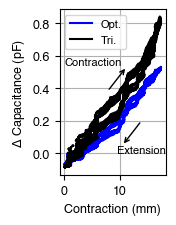

In [3]:
plt.figure(figsize=(1.8,2.3),facecolor=(1, 1, 1),tight_layout=True)
#change fig size in inch. Col width is 3.5 in, full width is 6.7 in

### PARSES plot style. Please don't adjust unless you don't want to be stylish!
#Font sizes for axis labels, annotations, etc.
SMALL_SIZE = 8
MEDIUM_SIZE = 9

plt.rcParams['font.sans-serif'] = ['Helvetica', 'DejaVu Sans','Lucida Grande', 'Verdana']

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

colors = ['b', 'k', 'g', 'c']

linewidth = 2

### END PARSES plot style

plt.plot(synced_data[:,0], synced_data[:,1], colors[0])
plt.plot(synced_data[:,0], synced_data[:,2], colors[1])

#axis labels
plt.xlabel('Contraction (mm)')
plt.ylabel('$\Delta$ Capacitance (pF)')


#example annotations 
plt.annotate(
    'Contraction',
    xy=(0, 0.54), xycoords='data')
plt.annotate(
	'',
    xy=(7.8, 0.38), xycoords='data',
    xytext=(14, 18), textcoords='offset points',
    arrowprops=dict(arrowstyle="<-"))

plt.annotate(
    'Extension',
    xy=(9.5, 0), xycoords='data')
plt.annotate(
	'',
    xy=(14, 0.2), xycoords='data',
    xytext=(-14,-18), textcoords='offset points',
    arrowprops=dict(arrowstyle="<-"))

#legend information. Whatever you plot first should go first in the list
plt.legend(['Opt.','Tri.'])
plt.grid('True')

plt.savefig(inputfile + 'out.png', dpi=300.0, format='png', metadata=None,
        bbox_inches=None, 
        facecolor='auto', edgecolor='auto', transparent=False,
        backend=None)

plt.show()
